<a href="https://colab.research.google.com/github/sumittagadiya/Image-super-resolution/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.data.experimental import AUTOTUNE
os.chdir('/content/drive/MyDrive/CS2')

In [4]:
!ls

CS2_EDA.ipynb  preprocessing.ipynb


# Data preparation and preprocessing

In [6]:
class DIV2K_DATA:
    ''' This class will download data at root directory and 
    directly we can use data for training'''

    def __init__(self,
                 scale=2, # 2, 3, 4 or 8
                 subset='train', # train or validation
                 downgrade='bicubic', # 'bicubic', 'unknown', 'mild' or 'difficult'
                 images_dir='div2k/images', # image directory
                 caches_dir='div2k/caches'): # caches directory

             
        self._ntire_2018 = True  # ntire_2018 or ntire_2017

        _scales = [2, 3, 4, 8]   # scaling factors


        # scale condition
        if scale in _scales:
            self.scale = scale
        else:
            raise ValueError(f'scale value must be in ${_scales}')
        
        # subset condition 'train' or 'validation'
        if subset == 'train':
            self.image_ids = range(1, 801)
        elif subset == 'valid':
            self.image_ids = range(801, 901)
        else:
            raise ValueError("subset must be 'train' or 'valid'")

        # downgrade lists
        _downgrades_a = ['bicubic', 'unknown']
        _downgrades_b = ['mild', 'difficult']

        # NOTE : refer https://data.vision.ee.ethz.ch/cvl/DIV2K/ 

        if downgrade == 'bicubic' and scale == 8:
            # if downgrade is bicubic and scale = 8 then downgrade with x8
            # path : http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
            self.downgrade = 'x8'

        elif downgrade in _downgrades_b:
            # if downgrade is 'mild' or 'difficult' then downgrade respectively
            # path : http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_mild.zip
            self.downgrade = downgrade

        else:
            # if downgrade is not 'bicubic' and scale 8 or if downgrade not 'mild',
            # 'difficult' then challange is not ntire_2018.
            self.downgrade = downgrade
            self._ntire_2018 = False
        
        if scale == 8 and downgrade != 'bicubic':
            raise ValueError(f'scale 8 must have bicubic downgrade')

        if downgrade in _downgrades_b and scale != 4:
            raise ValueError(f'{downgrade} downgrade requires scale 4')

        self.subset = subset
        self.images_dir = images_dir
        self.caches_dir = caches_dir

        # create directories if not already exist
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(caches_dir, exist_ok=True)

    def __len__(self):
        ''' This function will return length of respected dataset'''
        return len(self.image_ids)


    # LR and HR images dir have paths of Low resolution and High resolution images.
    def _LR_images_dir(self):

        '''This function will return absolute path of dataset to download as per ntire_2018 
        or ntire_2017'''

        if self._ntire_2018:
            # return path as per ntire_2018 download path name
            # path : http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8
            return os.path.join(self.images_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}')
        else:
            # return path as per ntire_2017 download path name
            # path : http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2
            return os.path.join(self.images_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}',
                                f'X{self.scale}')

    def _HR_images_dir(self):
        # path from div2k official site : 
        # http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR
        return os.path.join(self.images_dir, f'DIV2K_{self.subset}_HR')

    # LR and HR images archive function have absolute download link of zip folder

    def _LR_images_archive(self):
        ''' Low resolution images archive path'''
        if self._ntire_2018:
            # http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
            return f'DIV2K_{self.subset}_LR_{self.downgrade}.zip'
        else:
            # http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
            return f'DIV2K_{self.subset}_LR_{self.downgrade}_X{self.scale}.zip'

    def _HR_images_archive(self):
        ''' High resolution image archive path'''
        # http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
        return f'DIV2K_{self.subset}_HR.zip'
    
    # Low resolution image file funtion has LR image path because it is different 
    # in ntire_2018 and n_tire 2017 comeptition

    def _LR_image_file(self, image_id):
        ''' It returns Low resolution image path as per condition ntire_2018 or scale'''
        if not self._ntire_2018 or self.scale == 8:
            # eg. 0001x2.png, 0002x2.png, ..., 0800x2.png train LR images
            return f'{image_id:04}x{self.scale}.png'
        else:
            return f'{image_id:04}x{self.scale}{self.downgrade[0]}.png'

    # LR and HR image files function have absolute path of each LR and HR image files.

    def _LR_image_files(self):
        '''It returns Low resolution images absolute path'''
        images_dir = self._LR_images_dir()
        return [os.path.join(images_dir, 
                             self._LR_image_file(image_id)) for image_id in self.image_ids]

    def _HR_image_files(self):
        '''It returns High resolution images absolute path'''
        # eg. 0001.png, 0002.png....High Resolution Images
        images_dir = self._HR_images_dir()
        return [os.path.join(images_dir, 
                             f'{image_id:04}.png') for image_id in self.image_ids]
    
    # LR and HR cache file function have cache files of LR and HR images
    def _LR_cache_file(self):
        '''It returns cache file path of low resolution images'''
        return os.path.join(self.caches_dir, 
                            f'DIV2K_{self.subset}_LR_{self.downgrade}_X{self.scale}.cache')

    def _HR_cache_file(self):
        ''' It returns cache file path of high resolution images'''
        return os.path.join(self.caches_dir, f'DIV2K_{self.subset}_HR.cache')

    # LR and HR cache index function have index of cache files
    def _LR_cache_index(self):
        ''' It returns index of LR cache file'''
        return f'{self._LR_cache_file()}.index'

    def _HR_cache_index(self):
        ''' It returns index of HR cache file index'''
        return f'{self._HR_cache_file()}.index'


    # -----------------------------------------------------------
    #  Static methods
    # -----------------------------------------------------------
    
    @staticmethod
    def _Images_dataset(image_files):
        # this function decode png files in an efficient way
        ds = tf.data.Dataset.from_tensor_slices(image_files)
        ds = ds.map(tf.io.read_file)
        ds = ds.map(lambda x: tf.image.decode_png(x, channels=3),
                    num_parallel_calls=AUTOTUNE)
        return ds

    @staticmethod
    def _populate_cache(ds, cache_file):
        print(f'Caching decoded images in {cache_file} ...')
        for _ in ds: pass
        print(f'Cached decoded images in {cache_file}.')

    # -----------------------------------------------------------
    #  Create LR_dataset and HR_dataset
    # -----------------------------------------------------------

    def LR_dataset(self):
        ''' This function creates low resolution image dataset'''
        if not os.path.exists(self._LR_images_dir()):
            download_archive(self._LR_images_archive(), self.images_dir, extract=True)

        ds = self._Images_dataset(self._LR_image_files()).cache(self._LR_cache_file())

        if not os.path.exists(self._LR_cache_index()):
            self._populate_cache(ds, self._LR_cache_file())

        return ds

    def HR_dataset(self):
        ''' This function creates high resolution image dataset '''
        if not os.path.exists(self._HR_images_dir()):
            download_archive(self._HR_images_archive(), self.images_dir, extract=True)

        ds = self._Images_dataset(self._HR_image_files()).cache(self._HR_cache_file())

        if not os.path.exists(self._HR_cache_index()):
            self._populate_cache(ds, self._HR_cache_file())

        return ds
    
    # -----------------------------------------------------------
    #  Final Dataset
    # -----------------------------------------------------------

    def dataset(self, batch_size=16, repeat_count=None, random_transform=True):
        # take LR and HR image Symanteneously
        ds = tf.data.Dataset.zip((self.LR_dataset(), self.HR_dataset()))
        # random transform will apply only on train dataset
        if random_transform:
            # random cropping
            ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=self.scale),
                        num_parallel_calls=AUTOTUNE)
            # random rotate
            ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
            # random flip
            ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
        # ds.batch() will take images in given batch size
        ds = ds.batch(batch_size)
        # it will repeat dataset. if repeat_count() = None then infinite cardinality
        ds = ds.repeat(repeat_count)
        # ds.prefetch() will prefetch data for given buffer_size
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds


# Image augmentation like cropping, rotating, flipping

In [7]:
# -----------------------------------------------------------
#  Augmentation (crop, flip, rotate)
# -----------------------------------------------------------

def random_crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    ''' This function crops lr(47x47) and hr(96x96) images'''
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_width = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_height = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_width = lr_width * scale
    hr_height = lr_height * scale

    lr_img_cropped = lr_img[lr_height:lr_height + lr_crop_size, lr_width:lr_width + lr_crop_size]
    hr_img_cropped = hr_img[hr_height:hr_height + hr_crop_size, hr_width:hr_width + hr_crop_size]

    return lr_img_cropped, hr_img_cropped

def random_flip(lr_img, hr_img):
    ''' This function will flip imag left_right randomly'''
    random = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(random < 0.5,lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))
        
def random_rotate(lr_img, hr_img):
    ''' This function will rotate image randomly to 90 degree'''
    rand = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rand), tf.image.rot90(hr_img, rand)

In [8]:
# Download Archive function extracts High Resolution and LR Resolution images.

def download_archive(file, target_dir, extract=True):
    ''' This function extract images into cache directory '''
    source_url = f'http://data.vision.ee.ethz.ch/cvl/DIV2K/{file}'
    target_dir = os.path.abspath(target_dir)
    tf.keras.utils.get_file(file, source_url, cache_subdir=target_dir, extract=extract)
    os.remove(os.path.join(target_dir, file))

In [9]:
# Super-resolution factor
scale = 4
# Downgrade operator
downgrade = 'bicubic'

In [10]:
div2k_train = DIV2K_DATA(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K_DATA(scale=scale, subset='valid', downgrade=downgrade)

In [11]:
!ls

CS2_EDA.ipynb  div2k  preprocessing.ipynb


In [12]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

246915072/246914039 [==============================] - 29s 0us/step
Caching decoded images in div2k/caches/DIV2K_train_LR_bicubic_X4.cache ...
Cached decoded images in div2k/caches/DIV2K_train_LR_bicubic_X4.cache.
3530604544/3530603713 [==============================] - 406s 0us/step
Caching decoded images in div2k/caches/DIV2K_train_HR.cache ...
Cached decoded images in div2k/caches/DIV2K_train_HR.cache.
31506432/31505881 [==============================] - 3s 0us/step
Caching decoded images in div2k/caches/DIV2K_valid_LR_bicubic_X4.cache ...
Cached decoded images in div2k/caches/DIV2K_valid_LR_bicubic_X4.cache.
448995328/448993893 [==============================] - 49s 0us/step
Caching decoded images in div2k/caches/DIV2K_valid_HR.cache ...
Cached decoded images in div2k/caches/DIV2K_valid_HR.cache.


In [ ]:
#train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
#valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

Caching decoded images in div2k/caches/DIV2K_train_HR.cache ...


In [14]:
print('Number of HR Train Images = ',
      len(os.listdir('/content/drive/MyDrive/CS2/div2k/images/DIV2K_train_HR')))
print('Number of LR Train Images',
      len(os.listdir('/content/drive/MyDrive/CS2/div2k/images/DIV2K_train_LR_bicubic/X4')))
print('Number of HR Validation Images = ',
      len(os.listdir('/content/drive/MyDrive/CS2/div2k/images/DIV2K_valid_HR')))
print('Number of LR Validation Images = ',
      len(os.listdir('/content/drive/MyDrive/CS2/div2k/images/DIV2K_valid_LR_bicubic/X4')))

Number of HR Train Images =  800
Number of LR Train Images 800
Number of HR Validation Images =  100
Number of LR Validation Images =  100


In [15]:
# train data has Infinite cardinality because of ds.repeat()
print((train_ds.cardinality() == tf.data.INFINITE_CARDINALITY).numpy())

True


In [16]:
print('train_ds cardinality is ==> ', train_ds.cardinality().numpy())
print('valid_ds cardinality is ==> ', valid_ds.cardinality().numpy())

train_ds cardinality is ==>  -1
valid_ds cardinality is ==>  100


In [17]:
# function to plot Low and High resolution images

def plot_images(tf_dataset,n_rows,figsize=(30,30)):
    # subplots
    fig,axes = plt.subplots(nrows =n_rows, ncols = 2, figsize=figsize)
    for ax in axes.flatten():
        ax.axis('off')
    count = -1
    for element1,element2 in tf_dataset.take(n_rows).as_numpy_iterator():
        count+=1
        print('LR Shape is {} and HR shape is {}'.format(element1[0].shape,element2[0].shape))
        axes[count,0].set_title('Low resolution',fontdict={'fontsize': 25,'fontweight': 'bold'})
        axes[count,0].imshow(element1[0])
        axes[count,1].set_title('High Resolution',fontdict={'fontsize': 25,'fontweight': 'bold'})
        axes[count,1].imshow(element2[0])


LR Shape is (339, 510, 3) and HR shape is (1356, 2040, 3)
LR Shape is (339, 510, 3) and HR shape is (1356, 2040, 3)


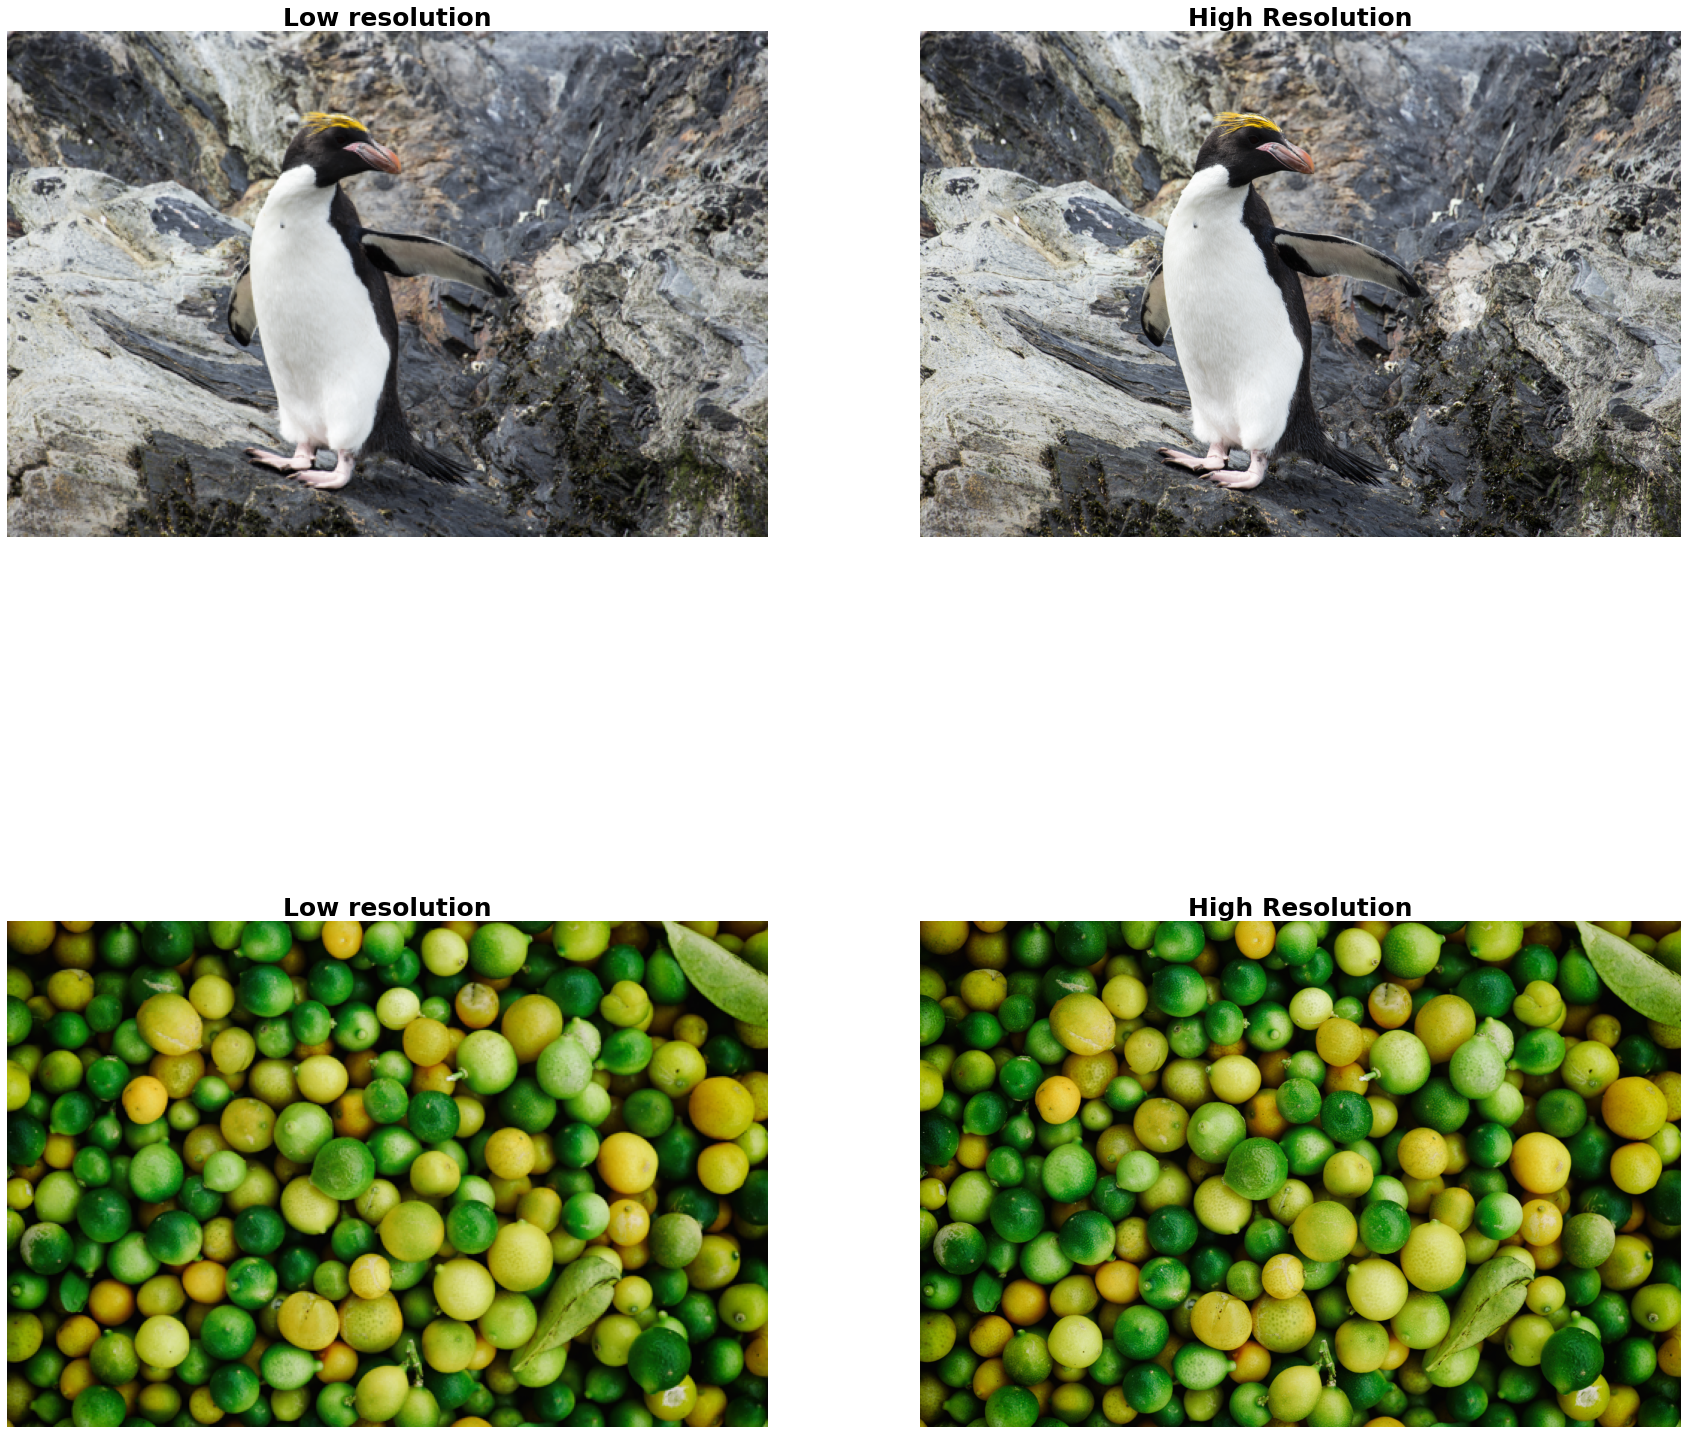

In [21]:
# Low and High resolution validation dataset
plot_images(valid_ds,2)

LR Shape is (24, 24, 3) and HR shape is (96, 96, 3)
LR Shape is (24, 24, 3) and HR shape is (96, 96, 3)


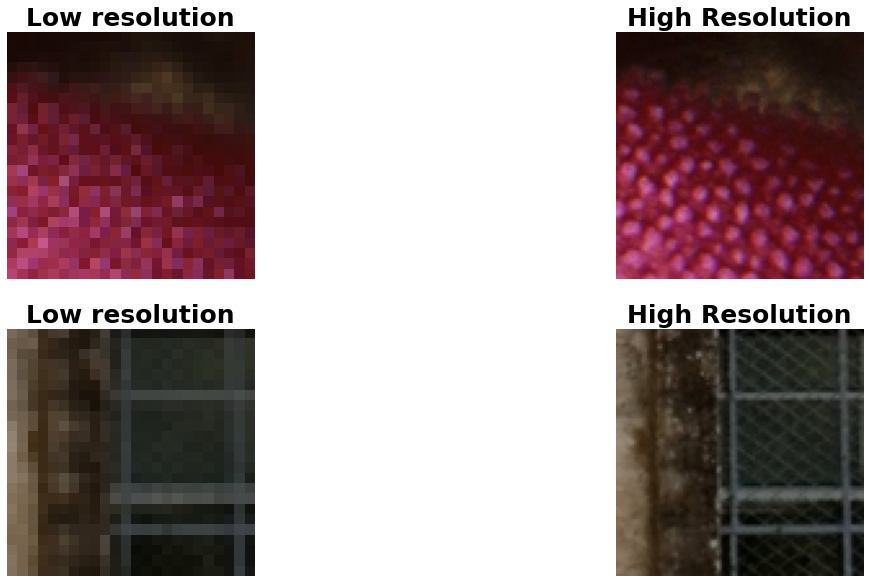

In [23]:
# Low and High resolution images of train dataset
plot_images(train_ds,2,figsize=(20,10))